In [2]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
df = pd.read_csv('df')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.rename(columns={'booking_complete':'target'}, inplace=True)
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,target
0,2,0,2,262,19,7,2,0,61,1,0,0,5.52,0
1,1,0,2,112,20,3,2,0,61,0,0,0,5.52,0
2,2,0,2,243,22,17,6,0,36,1,1,0,5.52,0
3,1,0,2,96,31,4,2,0,61,0,0,1,5.52,0
4,2,0,2,68,22,15,6,0,36,1,0,1,5.52,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  int64  
 2   trip_type              50000 non-null  int64  
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  int64  
 8   booking_origin         50000 non-null  int64  
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  target                 50000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 5.3 MB


In [25]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('X_train shape is :{}'.format(X_train.shape))
print('y_train shape is :{}'.format(y_train.shape))
print('X_test shape is :{}'.format(X_test.shape))
print('y_test shape is :{}'.format(y_test.shape))

X_train shape is :(33500, 13)
y_train shape is :(33500,)
X_test shape is :(16500, 13)
y_test shape is :(16500,)


In [27]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

In [28]:
# Average CV score on the training set was: 0.9791152263374485
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.15000000000000002, min_samples_leaf=1, min_samples_split=4, n_estimators=100)),
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.5, max_depth=9, max_features=0.9000000000000001, min_samples_leaf=2, min_samples_split=7, n_estimators=100, subsample=0.9000000000000001)),
    ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.8500000000000001, min_samples_leaf=15, min_samples_split=3, n_estimators=100)
)

# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 1)

In [29]:
exported_pipeline.fit(X_train.values, y_train.values)

Pipeline(steps=[('stackingestimator-1',
                 StackingEstimator(estimator=ExtraTreesClassifier(max_features=0.15000000000000002,
                                                                  min_samples_split=4,
                                                                  random_state=1))),
                ('stackingestimator-2',
                 StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.5,
                                                                        max_depth=9,
                                                                        max_features=0.9000000000000001,
                                                                        min_samples_leaf=2,
                                                                        min_samples_split=7,
                                                                        random_state=1,
                                                                        subsample=0.9000000000000001))),
                ('extratreesclassifier',
                 ExtraTreesClassifier(max_features=0.8500000000000001,
                                      min_samples_leaf=15, min_samples_split=3,
                                      random_state=1))])

In [30]:
y_pred = exported_pipeline.predict(X_test.values)

Text(0.5, 23.52222222222222, 'Predicted label')

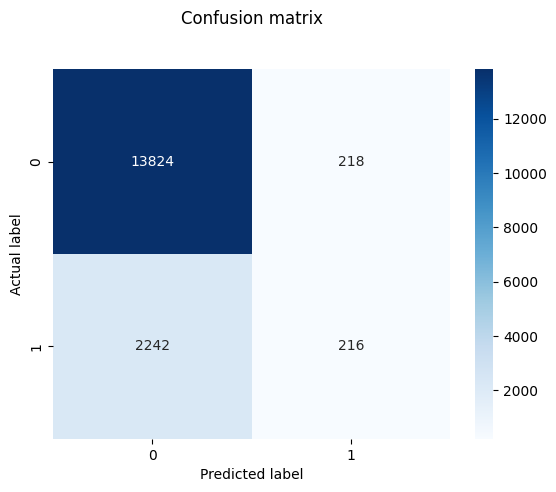

In [31]:
from sklearn import metrics
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap='Blues' ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### CLassification report

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,recall_score

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     14042
           1       0.50      0.09      0.15      2458

    accuracy                           0.85     16500
   macro avg       0.68      0.54      0.53     16500
weighted avg       0.81      0.85      0.80     16500



In [33]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.14937759336099585, 0.08787632221318145)

In [40]:
from sklearn.metrics import roc_auc_score

tpot_auc_score = roc_auc_score(y_test, exported_pipeline.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')


AUC score: 0.6121


In [36]:
#### Lets choose the best 5 features.

df2= df.copy()

X2 = df[['purchase_lead','route','booking_origin','flight_hour','length_of_stay']]
y2 = df['target']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=42)
print('X_train shape is :{}'.format(X_train2.shape))
print('y_train shape is :{}'.format(y_train2.shape))
print('X_test shape is :{}'.format(X_test2.shape))
print('y_test shape is :{}'.format(y_test2.shape))

X_train shape is :(33500, 5)
y_train shape is :(33500,)
X_test shape is :(16500, 5)
y_test shape is :(16500,)


Text(0.5, 23.52222222222222, 'Predicted label')

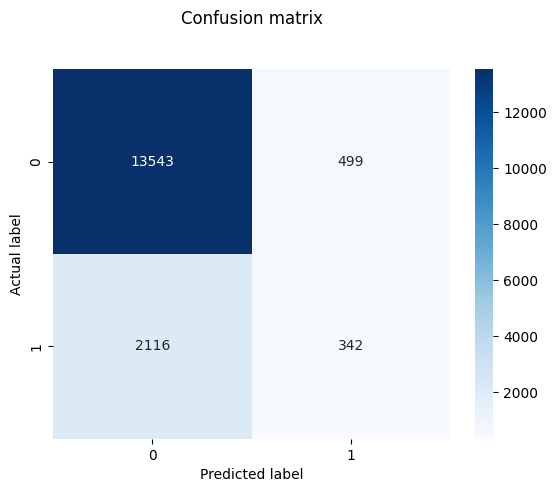

In [37]:
exported_pipeline.fit(X_train2.values, y_train2.values)
y_pred2 = exported_pipeline.predict(X_test2.values)

from sklearn import metrics
cf_matrix = metrics.confusion_matrix(y_test2, y_pred2)
p = sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap='Blues' ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [41]:
tpot_auc_score = roc_auc_score(y_test2, exported_pipeline.predict_proba(X_test2)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')


AUC score: 0.6121
